In [2]:
from functions.data_by_country import data_by_country
from utils.data_loader import load_data_parquet
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from functions.arma import ARMA
from functions.adf_check import adf_check
from functions.best_model_arma import best_model_arma
from functions.ar import AR
from functions.ma import MA
from functions.acf_pacf import acf_pacf
from utils.computations import compute_slopes, normalize_trend
from sklearn.preprocessing import MinMaxScaler
from functions.ols import OLS

# Part 1: Data cleaning and processing

In [ ]:
df = load_data_parquet()
df = data_by_country(df)
df = df.dropna()


c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\functions\data_by_country.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data[["Country", "AverageTemperature", "dt", "Country_ISO"]


In [ ]:
# To show how the ARMA model works, I've picked Sweden
df_sweden = df[df["Country"]=="Sweden"]
df_sweden3 = df_sweden.copy()
df_sweden3 = df_sweden3.set_index("dt")
df_sweden3

,Country,Country_ISO,AverageTemperature
dt,,,
1743-11-01,Sweden,SWE,3.7652
1744-04-01,Sweden,SWE,3.3624
1744-05-01,Sweden,SWE,8.8490
1744-06-01,Sweden,SWE,13.0116
1744-07-01,Sweden,SWE,15.6892
...,...,...,...
2013-04-01,Sweden,SWE,3.3374
2013-05-01,Sweden,SWE,11.9138
2013-06-01,Sweden,SWE,14.8738


In [ ]:
# Choosing some data to make the arima model with
df_sweden = df_sweden.loc[(df_sweden.dt >= "1950-01-01") & (df_sweden.dt <= "2013-08-01")]

df_sweden_2 = df_sweden.loc[(df_sweden.dt >= "2000-01-01") & (df_sweden.dt <= "2003-12-01")]

In [ ]:

df_sweden_2 = df_sweden_2[["dt","AverageTemperature"]]
df_sweden_2 = df_sweden_2.set_index("dt")

df_sweden = df_sweden[["dt","AverageTemperature"]]
df_sweden = df_sweden.set_index("dt")



In [ ]:
df_sweden_2

,AverageTemperature
dt,
2000-01-01,-0.0738
2000-02-01,0.3756
2000-03-01,1.5902
2000-04-01,5.9578
2000-05-01,11.3468
2000-06-01,13.4314
2000-07-01,15.2748
2000-08-01,15.0294
2000-09-01,11.0626


## First we look at the time series...

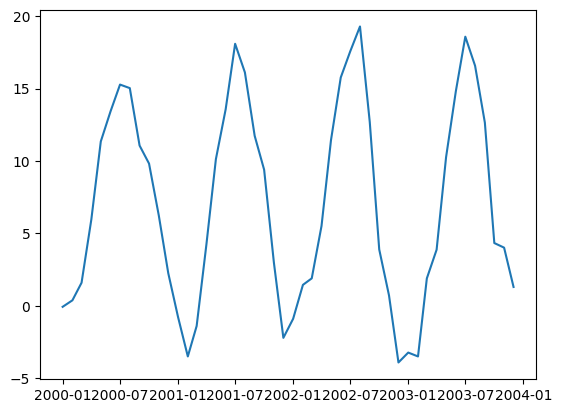

In [ ]:
plt.plot(df_sweden_2["AverageTemperature"])

## Then we have to make the data stationary

Sources: 
https://github.com/jinit24/ARIMA-Model/blob/master/ARIMA.ipynb 

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://puneet166.medium.com/time-series-forecasting-how-to-predict-future-data-using-arma-arima-and-sarima-model-8bd20597cc7b

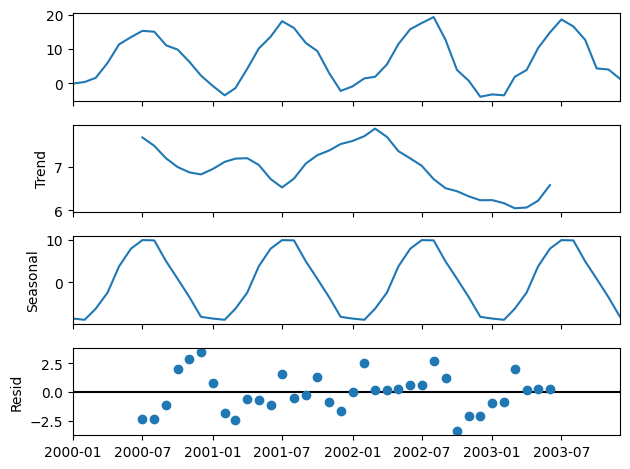

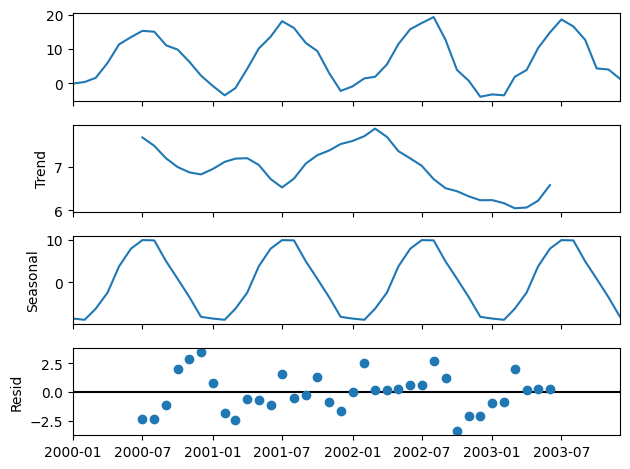

In [ ]:

decompose_data = seasonal_decompose(df_sweden_2, model="additive",period=12)
decompose_data.plot()

The Augmented Dickey-Fuller (ADF) test is used to check whether a time series is stationary or non-stationary by assessing the presence of a unit root. Stationary time series have constant statistical properties, while non-stationary time series exhibit changing properties over time. The ADF test formulates hypotheses and computes a test statistic and p-value, allowing you to determine whether the time series is stationary. Rejecting the null hypothesis suggests stationarity, while failing to reject it indicates non-stationarity. Stationarity is essential for selecting appropriate time series forecasting models, and the ADF test helps in making informed modeling decisions.

In [ ]:
result_adf = adf_check(df_sweden_2.AverageTemperature, "AIC")

Stationarity and seasonality are two related but distinct concepts in time series analysis:

1. Stationarity refers to a time series maintaining consistent statistical properties over time, including a constant mean, variance, and autocorrelation. This property simplifies modeling and is desirable for forecasting.

2. Seasonality involves recurring and predictable patterns or fluctuations within a time series, often related to calendar time intervals. These patterns can be daily, weekly, monthly, or yearly and result from external factors.

Importantly, a time series can exhibit both stationarity and seasonality simultaneously. Stationarity ensures that the overall statistical characteristics remain constant, while seasonality introduces regular, calendar-driven patterns on top of this stationary baseline. The coexistence of these features is common and can be explained by understanding their distinct roles in characterizing time series data.


## Do we need to shift the data? 

https://people.duke.edu/~rnau/411arim2.htm

According to the adf_check, our data is stationary which means that we do not need to shift the data. Therefore, in this case our model becomes an ARMA model. The difference between an ARMA model and ARIMA model is the differencing (shifting) of data.

In [ ]:
# Example code to remove seasonality with differencing
#df_sweden_2["temperatures_shifted"]= df_sweden_2["AverageTemperature"].diff(12)

In [ ]:
df_sweden_2

,AverageTemperature
dt,
2000-01-01,-0.0738
2000-02-01,0.3756
2000-03-01,1.5902
2000-04-01,5.9578
2000-05-01,11.3468
2000-06-01,13.4314
2000-07-01,15.2748
2000-08-01,15.0294
2000-09-01,11.0626


## ACF and PACF
ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots are essential tools for determining the order of autoregressive (AR) and moving average (MA) terms, denoted as "p" and "q," respectively, in time series analysis.

ACF measures the correlation between a time series and its lagged values at various lags.
PACF measures the correlation between a time series and its lagged values while removing the influence of shorter lags.
A sharp drop in the ACF plot after a certain lag suggests an AR term, and the number of significant lags helps identify "p."
A sharp drop in the PACF plot after a certain lag suggests an MA term, and the number of significant lags helps identify "q."

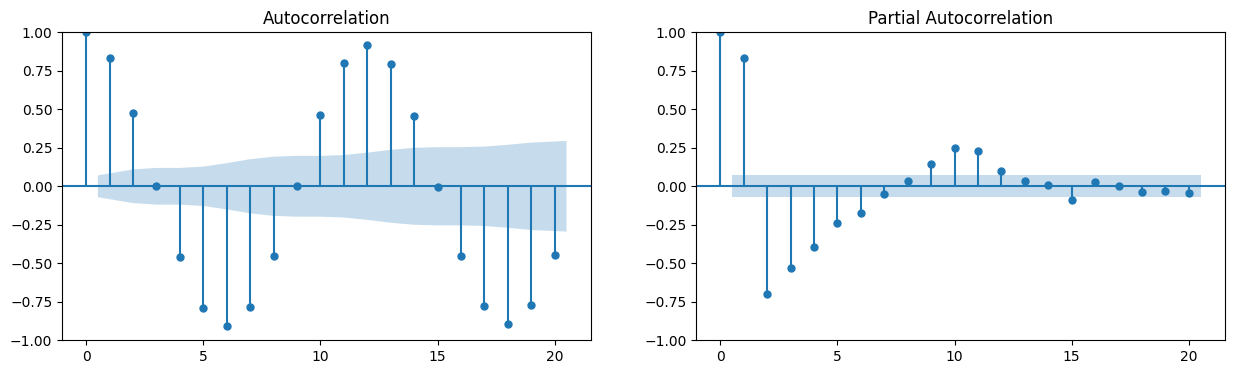

In [ ]:
acf_pacf(df_sweden.AverageTemperature,20)

Based on acf, we have 2 lags, and with pacf 5 lags. Therefore, we should test the arima model from 2-5 lags

# Part 2: Fitting an Auto-Regressive (AR) model

In [ ]:
# Removing columns we dont need
#df_testing = df.copy()
df_testing = df_sweden.copy()
df_testing = df_testing[["AverageTemperature"]]

df_testing2 = df_sweden_2.copy()
df_testing2 = df_testing2[["AverageTemperature"]]
#df_testing

An AutoRegressive (AR) model is a fundamental time series model used for forecasting. It's a linear model that captures the relationship between a time series and its past values. The primary idea behind an AR model is that the current value of a time series can be predicted as a linear combination of its past values, often referred to as lags.

Mathematically, an $AR(p)$ model of order $p$ can be expressed as:

$ Y_t = \beta_0 + \beta_1*Y_{t-1} + \beta_2*Y_{t-2} + … + \beta_p*Y_{t-p} + ϵₜ$

Where:

* $ Y_t $ is the value of the time series at time $t$ 
* $\beta_0$ is a constant (intercept) term.
* $\beta_1, \beta_2, ..., \beta_p$ are the coefficients of the model representing the relationship between the current value and the past values.
* $ Y_{t-1}, Y_{t-2}, ..., Y_{t-p}$ are the lagged values of the time series at time ${t-1}, {t-2}, ...,{t-p}$.
* $ ϵₜ$ is a white noise error term at time $t$, representing random fluctuations that are not explained by the model.

In the AR model, we estimate the coefficients $\beta_1, \beta_2, ..., \beta_p$ and the constant term $\beta_0$ using Ordinary Least Squares (OLS) linear regression. OLS helps us find the values of these parameters that minimize the sum of squared residuals, making our predictions as accurate as possible based on the historical data.

We split the data into 80% training data and 20% testing data.

In [ ]:
[df_train_2, df_test, coef, intercept, RMSE, MSE, res] = AR(df_testing2,3)

The RMSE is : 2.3547073401862875 , Value of p :  3


Plotting the predicted values vs the actual values

<Axes: xlabel='dt'>

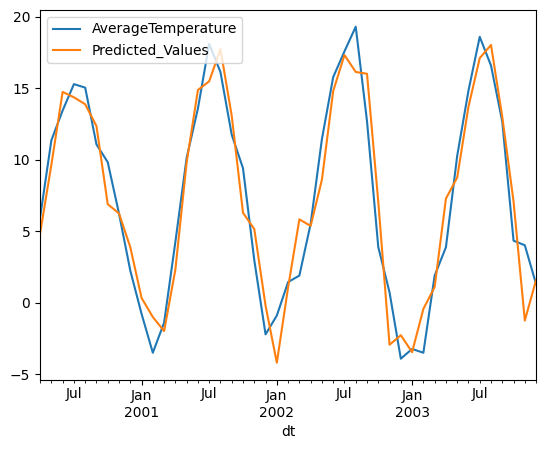

In [ ]:
df_c = pd.concat([df_train_2,df_test])
df_c[['AverageTemperature','Predicted_Values']].plot()

# Part 3: Fitting the Moving Average (MA) model on residuals

A Moving Average (MA) model is another essential time series model used for forecasting. Unlike the AutoRegressive (AR) model, which focuses on the relationship between a time series and its past values, the MA model centers on capturing the relationship between the current value of a time series and its past white noise error terms.

For the MA model, we first use an AutoRegressive (AR) model to capture systematic patterns and dependencies in past values, followed by using the residuals from the AR model as inputs to the MA component. The residuals (error) comes from taking the difference between the actual value of the AR model and the predicted value.

Mathematically, an $MA(p)$ model of order $p$ can be expressed as:

$$ Y_t = \mu + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + … + \theta_p \epsilon_{t-p} + \epsilon_t $$

Where:

- $Y_t$ is the value of the time series at time $t$.
- $\mu$ is the mean or average of the time series.
- $\theta_1, \theta_2, ..., \theta_p$ are the coefficients of the model representing the relationship between the current value and the past error terms.
- $\epsilon_{t-1}, \epsilon_{t-2}, ..., \epsilon_{t-p}$ are the lagged error terms of the time series at time $t-1, t-2, ..., t-p$.
- $\epsilon_t$ is a white noise error term at time $t$, representing random fluctuations that are not explained by the model.

Both AR and MA components utilize Ordinary Least Squares (OLS) linear regression to estimate coefficients and the mean, aiming to minimize the sum of squared residuals for accurate predictions.



In [ ]:
[res_train_2, res_test, coef, intercept,MSE, RMSE] = MA(res,5)

The RMSE is : 2.462197031301289 , Value of q :  5


<Axes: xlabel='dt'>

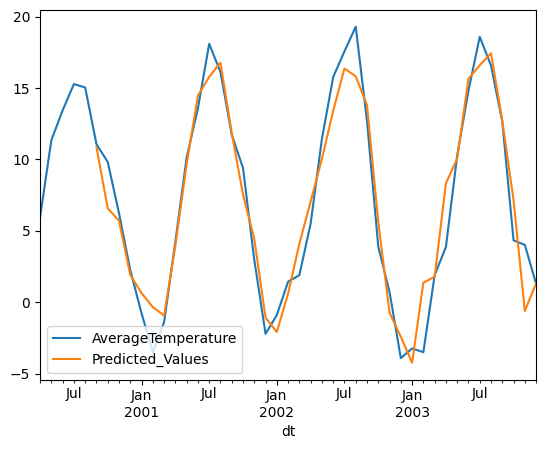

In [ ]:
res_c = pd.concat([res_train_2,res_test])
df_c.Predicted_Values += res_c.Predicted_Values
df_c[['AverageTemperature','Predicted_Values']].plot()

The code "df_ar.Predicted_Values += res_c.Predicted_Values" combines predictions from an AutoRegressive (AR) model and a Moving Average (MA) model in an AutoRegressive Moving Average (ARMA) model. This combination aims to leverage the strengths of both models. The AR model captures systematic trends and dependencies on past values, while the MA model captures short-term fluctuations and unexplained variations. By adding the predictions from the MA model to the AR model's predictions, the ARMA model creates a more accurate forecast that accounts for both long-term and short-term patterns in the time series data.

# Part 4: Combine the AR(p) and MA(q) model to create an ARMA(p,q) model

An AutoRegressive Moving Average (ARMA(p, q)) model is a time series forecasting model that combines the AutoRegressive (AR) and Moving Average (MA) processes to capture and explain the underlying patterns in time series data.

Mathematically, an ARMA(p, q) model of order p and q can be expressed as:

$ Yₜ = β₀ + β₁Yₜ₋₁ + β₂Yₜ₋₂ + … + βₚYₜ₋ₚ + εₜ + θ₁εₜ₋₁ + θ₂εₜ₋₂ + … + θₚεₜ₋ₚ$
 
Where:

* $Y_t$ represents the value of the time series at time $t$.
* $\beta_0$ is a constant (intercept) term.
* $\beta_1, \beta_2, \ldots, \beta_p$ are the coefficients of the AR component, indicating the strength and direction of the relationship between the current value and its past values up to lag $p$.
* $\varepsilon_t$ is a white noise error term at time $t$, representing the random component of the current value.
* $\theta_1, \theta_2, \ldots, \theta_q$ are the coefficients of the MA component, representing the impact of past error terms on the current value up to lag $q$.
* $\varepsilon_{t-1}, \varepsilon_{t-2}, \ldots, \varepsilon_{t-q}$ are the lagged error terms at time $t-1, t-2, \ldots, t-q$.


In summary, an ARMA(p, q) model combines both the AR and MA components to create a comprehensive model for time series data. It acknowledges that the current value of the time series is influenced by its own past values (AR) and by past error terms (MA). The model is used for time series forecasting and analysis, aiming to capture and explain the patterns and dependencies in historical data to make accurate predictions about future values of the time series.

In [ ]:
[df_ar,MSE,RMSE] = ARMA(df_testing2,5,4)

<Axes: xlabel='dt'>

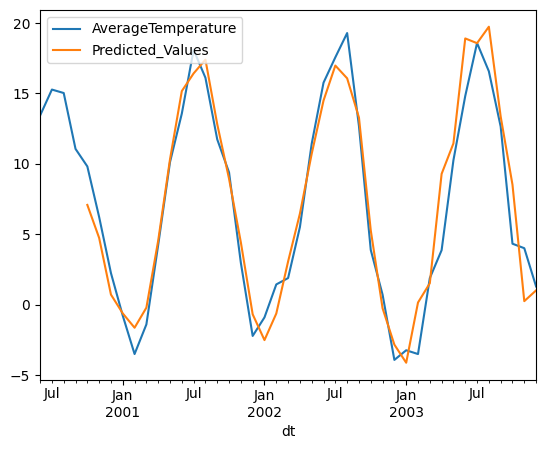

In [ ]:
df_ar[["AverageTemperature", "Predicted_Values"]].plot()

# Part 5: Choosing the best model

MSE (Mean Squared Error) and RMSE (Root Mean Squared Error) are valuable metrics for evaluating and comparing the performance of ARMA (AutoRegressive Moving Average) models, especially when choosing the best model among multiple candidates. These metrics quantify the accuracy of model predictions by measuring the squared differences between predicted and actual values in a test dataset. Lower MSE and RMSE values indicate better model performance, making them crucial for selecting the most accurate forecasting model. However, it's advisable to consider other factors like model interpretability and computational complexity alongside MSE and RMSE to make a well-informed decision about model selection.

 While MSE and RMSE are commonly used due to their simplicity and ease of interpretation, considering multiple metrics and conducting a thorough analysis of model diagnostics can lead to a more robust model selection process. 

 Examples of other metrics we could use:
 * AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion): These metrics take into account the model's goodness of fit and complexity, penalizing models with too many parameters. Lower AIC or BIC values indicate a better trade-off between model fit and complexity.
 * Adjusted R-squared: In regression-based models like ARMA, adjusted R-squared assesses the proportion of variance in the dependent variable that is explained by the model while accounting for the number of predictors. Higher adjusted R-squared values indicate better model fit.

 However, for simplicity sake, we opted for MSE and RMSE.

In [ ]:
# The function "best_model_arma" prints the best model according to MSE and RMSE separately. 
# If the best models have different p and q values, both models should be made and tested against each other.
best_mse, best_rmse = best_model_arma(df_testing2, 5,4)



In this case, the best model according to both MSE and RMSE is p = 3 and q = 1!

In [ ]:
[final_model,MSE,RMSE] = ARMA(df_testing2,3,1)

In [ ]:
final_model

,AverageTemperature,Shifted_values_1,Shifted_values_2,Shifted_values_3,Predicted_Values
dt,,,,,
2000-04-01,5.9578,1.5902,0.3756,-0.0738,NaN
2000-05-01,11.3468,5.9578,1.5902,0.3756,9.361827
2000-06-01,13.4314,11.3468,5.9578,1.5902,14.309383
2000-07-01,15.2748,13.4314,11.3468,5.9578,14.656161
2000-08-01,15.0294,15.2748,13.4314,11.3468,13.637150
2000-09-01,11.0626,15.0294,15.2748,13.4314,12.057408
2000-10-01,9.8188,11.0626,15.0294,15.2748,7.179997
2000-11-01,6.2276,9.8188,11.0626,15.0294,5.523996
2000-12-01,2.2456,6.2276,9.8188,11.0626,3.874779


<Axes: xlabel='dt'>

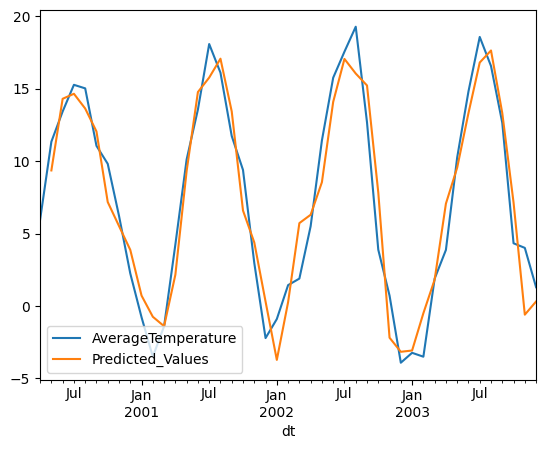

In [ ]:
final_model[["AverageTemperature", "Predicted_Values"]].plot()

# What about an ARIMA model?

If we had to difference the data earlier, we would have to de-difference the data before plotting the data.

# What about future values?

In [3]:
df_slope = load_data_parquet()
df_slope = data_by_country(df_slope)
df_slope = df_slope.dropna()



c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\functions\data_by_country.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data[["Country", "AverageTemperature", "dt", "Country_ISO"]


In [4]:
# df_slope = df_slope.pivot(index="dt", columns="Country",
#               values='AverageTemperature').dropna()
df_slope = df_slope.set_index("dt")


In [ ]:
df_slope

,Country,Country_ISO,AverageTemperature
dt,,,
1833-01-01,Afghanistan,AFG,1.145000
1833-02-01,Afghanistan,AFG,2.168400
1833-03-01,Afghanistan,AFG,6.516200
1833-04-01,Afghanistan,AFG,12.832200
1833-05-01,Afghanistan,AFG,18.544800
...,...,...,...
2013-04-01,Zimbabwe,ZWE,19.770143
2013-05-01,Zimbabwe,ZWE,17.851714
2013-06-01,Zimbabwe,ZWE,16.527143


In [ ]:
testing = df_slope.copy()
testing = testing.dropna()
testing

,Country,Country_ISO,AverageTemperature
dt,,,
1833-01-01,Afghanistan,AFG,1.145000
1833-02-01,Afghanistan,AFG,2.168400
1833-03-01,Afghanistan,AFG,6.516200
1833-04-01,Afghanistan,AFG,12.832200
1833-05-01,Afghanistan,AFG,18.544800
...,...,...,...
2013-04-01,Zimbabwe,ZWE,19.770143
2013-05-01,Zimbabwe,ZWE,17.851714
2013-06-01,Zimbabwe,ZWE,16.527143


In [ ]:
trend_components = {}
slopes = {}
for country in df_slope2.columns:
    result = seasonal_decompose(df_slope2[country], model='additive', period=12)
    trend_components[country] = result.trend.dropna()
    
    # Fit a linear regression to calculate the slope of the trend component
    X = np.array(trend_components[country].values)
    y = trend_components[country].values
    #print(type(y))
    model = ols_linear_regression(X,y)
    
    # # Store the slope in the 'slopes' dictionary
    #slopes[country] = model[1]

all_trends = pd.concat(trend_components, axis=1)
# scaler = MinMaxScaler()
# all_normalized_trends = pd.DataFrame(scaler.fit_transform(
#     all_trends), index=all_trends.index, columns=all_trends.columns)

# # Calculate the slope based on the normalized trend
# for country in all_normalized_trends.columns:
#     x_data = range(len(all_normalized_trends[country]))
#     y_data = all_normalized_trends[country].dropna().values

#     slope, _ = np.polyfit(x_data, y_data, 1)
#     slopes[country] = slope

# sorted_countries = sorted(slopes, key=slopes.get, reverse=True)

# # Calculate growth rate as slopes for each country
# slopes_arr = np.array(list(slopes.values())).reshape(-1, 1)

all_trends



NameError: name 'df_slope2' is not defined

In [ ]:
results_from_arma = []

for i in all_trends.values:
    df_to_use = pd.DataFrame(i)
    df_to_use = df_to_use.rename(columns={0: "AverageTemperature"})
    results = ARMA(df_to_use,5,4)
    results_from_arma.append(results[0])


In [ ]:
results_from_arma = pd.concat(results_from_arma)

In [ ]:
results_from_arma

In [5]:
df_country = df_slope.groupby("Country",observed=False)



In [17]:
# First, group by both 'Country' and year and calculate the mean temperature
df_year = df_slope.groupby([df_slope.index.year])['AverageTemperature'].mean().reset_index()

# Rename the columns for clarity
df_year.columns = ['Year', 'AverageTemperature']

# Now, df_country_year contains the average temperature per year per country
df_year = df_year.dropna()

df_year = df_year.set_index("Year")

df_year

,Year,AverageTemperature
0,1743,5.323375
1,1744,10.760494
2,1745,1.588164
3,1750,9.681495
4,1751,9.815800
...,...,...
262,2009,19.480607
263,2010,19.522022
264,2011,19.324797
265,2012,19.390649


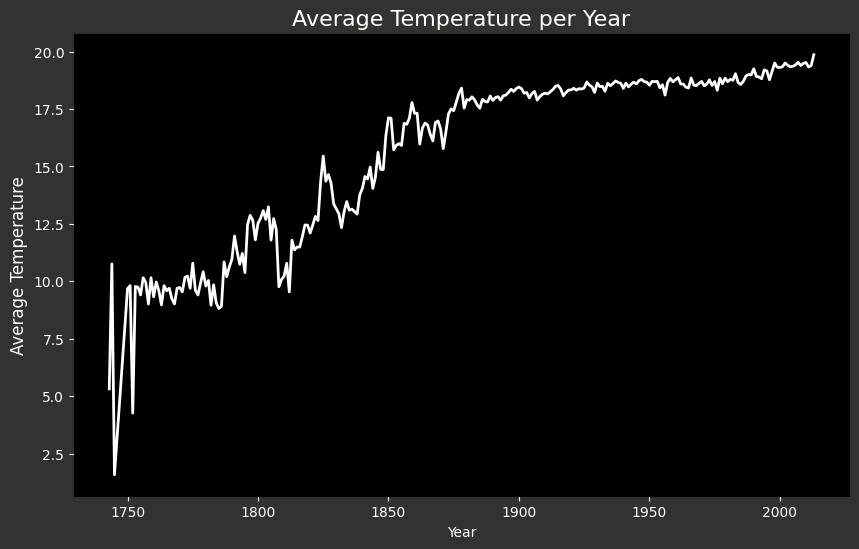

In [198]:
# Create a black background with white text plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_year["Year"], df_year['AverageTemperature'], color='white', linewidth=2)

# Set background color to black
ax.set_facecolor('black')


# Set labels and title with white text
ax.set_xlabel('Year', color='white')
ax.set_ylabel('Average Temperature', color='white', size=12)
ax.set_title('Average Temperature per Year', color='white', size=16)
fig.set_facecolor("#323331")
ax1.set_facecolor("#000100")
# Set ticks color to white
ax.tick_params(axis='both', colors='white')

# Show the plot
plt.show()

<Axes: xlabel='Year'>

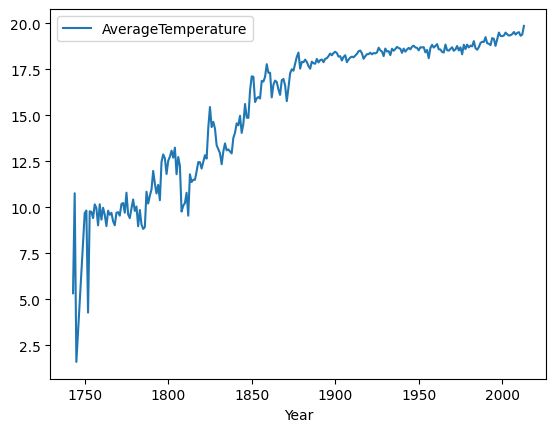

In [ ]:
df_year.plot()

In [92]:
# First, group by both 'Country' and year and calculate the mean temperature
df_monthly = df_slope.groupby([df_slope.index])['AverageTemperature'].mean().reset_index()


# Now, df_country_year contains the average temperature per year per country
df_monthly = df_monthly.dropna()


df_monthly['Year'] = df_monthly["dt"].dt.year
df_monthly['Month'] = df_monthly["dt"].dt.month
df_monthly = df_monthly[(df_monthly['Year'] >= 1800) & (df_monthly['Year'] <= 2012)]
#Reorder the columns if needed
df_monthly = df_monthly[['Year', 'Month', 'AverageTemperature']]
#df_monthly = df_monthly.set_index(['Year', 'Month'])
# Normalize the AverageTemperature column
# Calculate the mean and standard deviation for the AverageTemperature
mean_temperature = df_monthly['AverageTemperature'].mean()
std_temperature = df_monthly['AverageTemperature'].std()

# Normalize the AverageTemperature column using z-score
df_monthly['AverageTemperature'] = (df_monthly['AverageTemperature'] - mean_temperature) / std_temperature
#df_monthly = df_monthly.reset_index()
df_monthly.head()


,Year,Month,AverageTemperature
602,1800,1,-2.753734
603,1800,2,-2.498215
604,1800,3,-2.390239
605,1800,4,-0.521242
606,1800,5,-0.018877


In [93]:
print(df_monthly["AverageTemperature"].min())
df_monthly["AverageTemperature"].max()

-3.760875419932127


1.3994336139199257

In [ ]:
# First, group by both 'Country' and year and calculate the mean temperature
df_country_year = df_slope.groupby(['Country', df_slope.index.year])['AverageTemperature'].mean().reset_index()

# Rename the columns for clarity
df_country_year.columns = ['Country', 'Year', 'AverageTemperature']

# Now, df_country_year contains the average temperature per year per country
df_country_year = df_country_year.dropna()

df_country_year = df_country_year.set_index("Year")

df_country_year

C:\Users\gaute\AppData\Local\Temp\ipykernel_14636\2197161896.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_country_year = df_slope.groupby(['Country', df_slope.index.year])['AverageTemperature'].mean().reset_index()


,Country,AverageTemperature
Year,,
1833,Afghanistan,13.091150
1834,Afghanistan,13.093600
1835,Afghanistan,13.959233
1837,Afghanistan,14.537718
1838,Afghanistan,11.326802
...,...,...
2009,Zimbabwe,20.106405
2010,Zimbabwe,20.741714
2011,Zimbabwe,20.366060


<Axes: xlabel='Year'>

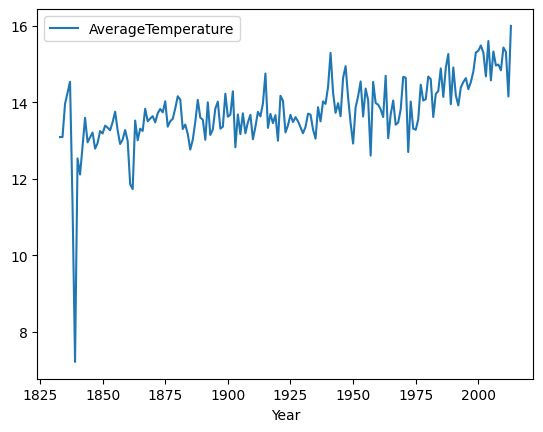

In [ ]:
new_df_3= df_country_year[df_country_year["Country"]=="Afghanistan"]
new_df_3.plot()


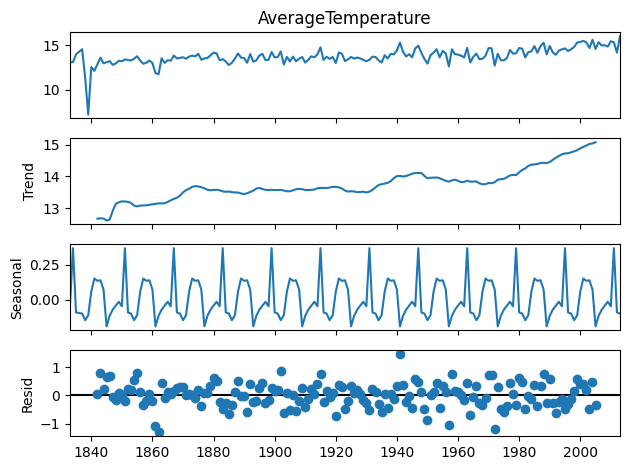

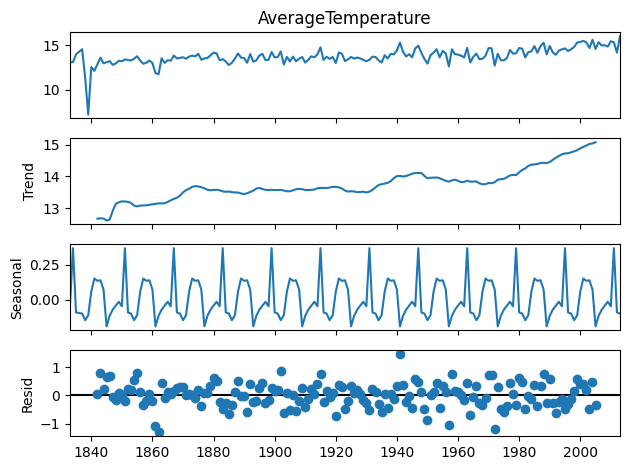

In [ ]:
decompose_data = seasonal_decompose(new_df_3.AverageTemperature, model="additive",period=16)
decompose_data.plot()

In [ ]:
# First, group by both 'Country' and year and calculate the mean temperature
df_country_dt = df_slope.groupby(['Country', df_slope.index])['AverageTemperature'].mean().reset_index()

# Rename the columns for clarity
df_country_dt.columns = ['Country', 'Date', 'AverageTemperature']

# Now, df_country_year contains the average temperature per year per country
df_country_dt = df_country_dt.dropna()

df_country_dt = df_country_dt.set_index("Date")

df_country_dt

C:\Users\gaute\AppData\Local\Temp\ipykernel_26376\278516903.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_country_dt = df_slope.groupby(['Country', df_slope.index])['AverageTemperature'].mean().reset_index()


,Country,AverageTemperature
Date,,
1833-01-01,Afghanistan,1.145000
1833-02-01,Afghanistan,2.168400
1833-03-01,Afghanistan,6.516200
1833-04-01,Afghanistan,12.832200
1833-05-01,Afghanistan,18.544800
...,...,...
2013-04-01,Zimbabwe,19.770143
2013-05-01,Zimbabwe,17.851714
2013-06-01,Zimbabwe,16.527143


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df_predicted2 = pd.DataFrame()

# Loop through each country
for country in df_country_year['Country'].unique():
    country_data = df_country_year[df_country_year['Country'] == country]

    # Fit an Exponential Smoothing model to the country's data
    model = ExponentialSmoothing(country_data['AverageTemperature'], trend='additive', seasonal='add', seasonal_periods=12) #seasonal='add', seasonal_periods=1
    model_fit = model.fit(optimized=True)

    # Predict future years (you can adjust the number of future years)
    future_years = np.arange(country_data.index.max() + 1, country_data.index.max() + 11)
    future_data = model_fit.forecast(steps=10)

    # Create a DataFrame for the predicted values and append it to df_predicted
    future_data = pd.DataFrame({
        'Country': [country] * len(future_years),
        'Year': future_years,
        'AverageTemperature': future_data
         })
    df_predicted2 = pd.concat([future_data, df_predicted2])
    
df_predicted2 = df_predicted2.set_index("Year")

c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.

In [ ]:
df_predicted2

,Country,AverageTemperature
Year,,
2014,Zimbabwe,20.419968
2015,Zimbabwe,20.410238
2016,Zimbabwe,20.535956
2017,Zimbabwe,20.423967
2018,Zimbabwe,20.504865
...,...,...
2019,Afghanistan,14.915817
2020,Afghanistan,15.080975
2021,Afghanistan,15.113075


In [ ]:
new_df = pd.concat([df_country_year,df_predicted2])

<Axes: xlabel='Year'>

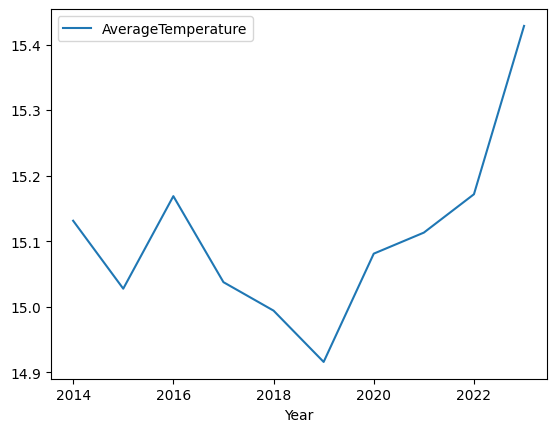

In [ ]:
new_df_= df_predicted2[df_predicted2["Country"]=="Afghanistan"]

new_df_.plot()

In [ ]:
# Create a DataFrame to store the predicted values
df_predicted = pd.DataFrame()

# Loop through each country
for country in df_country_year['Country'].unique():
    country_data = df_country_year[df_country_year['Country'] == country]

    # Perform seasonal decomposition to extract trend
    decomposition = seasonal_decompose(country_data['AverageTemperature'], model='additive', period=1)  # Assuming monthly data

    # Get the trend component
    trend = decomposition.trend.dropna()

    # Fit an Exponential Smoothing model to the trend component
    model = ExponentialSmoothing(trend, trend='additive')  # You can adjust the trend component model
    model_fit = model.fit(optimized=True)

    # Predict future years (you can adjust the number of future years)
    future_years = np.arange(country_data.index.max() + 1, country_data.index.max() + 11)
    future_trend = model_fit.forecast(steps=10)

    # Create a DataFrame for the predicted values and append it to df_predicted2
    future_data = pd.DataFrame({
        'Country': [country] * len(future_years),
        'Year': future_years,
        'AverageTemperature': future_trend
    })
    df_predicted = pd.concat([future_data, df_predicted])





c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.

In [ ]:
df_predicted

,Country,Year,AverageTemperature
158,Zimbabwe,2014,20.442009
159,Zimbabwe,2015,20.450410
160,Zimbabwe,2016,20.458811
161,Zimbabwe,2017,20.467212
162,Zimbabwe,2018,20.475613
...,...,...,...
185,Afghanistan,2019,15.162241
186,Afghanistan,2020,15.175829
187,Afghanistan,2021,15.189416
188,Afghanistan,2022,15.203004


In [ ]:
# Create a DataFrame to store the predicted values
df_predicted3 = pd.DataFrame(columns=['Country', 'Date', 'AverageTemperature'])

# Loop through each country
for country in df_country_dt['Country'].unique():
    country_data = df_country_dt[df_country_dt['Country'] == country]

    # Fit an Exponential Smoothing model to the country's data
    model = ExponentialSmoothing(country_data['AverageTemperature'], seasonal='add', seasonal_periods=12)  # Assuming seasonality of 12 for monthly data
    model_fit = model.fit(optimized=True)

    # Predict future dates (you can adjust the number of future months)
    last_date = country_data.index.max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=122, freq='MS')  # Monthly frequency
    future_data = model_fit.forecast(steps=122)

    # Create a DataFrame for the predicted values and append it to df_predicted
    future_data = pd.DataFrame({
        'Country': [country] * len(future_dates),
        'Date': future_dates,
        'AverageTemperature': future_data
    })
    df_predicted3 = pd.concat([df_predicted3, future_data])
    
df_predicted3 = df_predicted3.set_index("Date")


c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\gaute\AppData\Local\Temp\ipykernel_26376\1202590052.py:23: FutureWarnin

In [ ]:
df_predicted3

,Country,AverageTemperature
Date,,
2013-09-01,Afghanistan,21.023492
2013-10-01,Afghanistan,15.255028
2013-11-01,Afghanistan,8.854334
2013-12-01,Afghanistan,3.020321
2014-01-01,Afghanistan,1.364131
...,...,...
2023-06-01,Zimbabwe,16.143035
2023-07-01,Zimbabwe,15.378209
2023-08-01,Zimbabwe,17.454979


<Axes: xlabel='Date'>

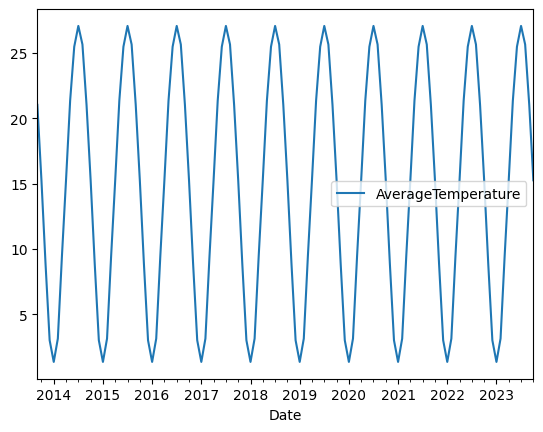

In [ ]:
new_df_2= df_predicted3[df_predicted3["Country"]=="Afghanistan"]
new_df_2.plot()

In [ ]:
df_c = df_country_dt[df_country_dt["Country"]=="Afghanistan"]
df_c

,Country,AverageTemperature
Date,,
1833-01-01,Afghanistan,1.145000
1833-02-01,Afghanistan,2.168400
1833-03-01,Afghanistan,6.516200
1833-04-01,Afghanistan,12.832200
1833-05-01,Afghanistan,18.544800
...,...,...
2013-04-01,Afghanistan,14.568250
2013-05-01,Afghanistan,20.976500
2013-06-01,Afghanistan,26.044500


In [ ]:
rows = df_country.size()
least_rows = rows.min()

In [ ]:
# How to do the ARMA for all countries
# Getting the country with least rows 
# and using the last "least_rows" to get matching number of rows
for i,j in df_country:
    data = j.tail(least_rows)
    data = data["AverageTemperature"]
    data = pd.DataFrame(data)
    #print(data)
    results = ARMA(data,5,4)
    
    a = results[0]
    a["Country"] = j["Country"]
    a["Country_ISO"]= j["Country_ISO"]
    print(a)
    

In [ ]:
# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame()

for i, j in df_country:
    # Extract the last rows with similar shape
    data = j.copy()
    data = data.tail(least_rows)
    
    # Perform seasonal decomposition
    result = seasonal_decompose(data.AverageTemperature, model='additive', period=12)
    
    # Get the trend component and drop NaN values
    trend_components = result.trend.dropna()
    
    # Ensure the indices match
    trend_components.index = data.index[-len(trend_components):]
    
    # Add the 'Trend' column to the data DataFrame
    data["Trend"] = trend_components
    
    # Concatenate the current data DataFrame with the result DataFrame
    data = data.dropna()
    #data1 = pd.DataFrame(data, columns="Trend")
    # result_df = pd.concat([result_df, data])
    # result_df = result_df.dropna()
    #print(type(data))
    data_to_use = data["Trend"]
    data_to_use = pd.DataFrame(data_to_use)
    #print(data_to_use)
    data_to_use.rename(columns={"Trend": "AverageTemperature"}, inplace=True)
    #print(data_to_use)
    results = ARMA(data_to_use,5,4)
  
    a = results[0]
    a["Country"] = j["Country"]
    a["Country_ISO"]= j["Country_ISO"]
    print(a)
    result_df = pd.concat([result_df, a])
    #best_p = []
    
    # #rename column to use as "AverageTemperature"
    # adf = adf_check(data_to_use,"AIC")
    # print(adf[1])
    # Checking for stationaity in two steps
    # if adf[1] <= 0.05:
    #     result = best_model_arma(data_to_use,10,10)
    # if adf[1] > 0.05:
    #     # Time series is non- stationary
    #     result_df["trend_shifted"]= data_to_use["Trend"].shift(12)
    #     adf = adf_check(result_df.trend_shifted, "AIC")
    #     if adf[1] > 0.05:
    #         result_df["trend_shifted_log"]= np.log(result_df["trend_shifted"])
    #         adf = adf_check(result_df.trend_shifted_log, "AIC")
            
    
# Print or use the result_df DataFrame
#print(result_df)

            AverageTemperature  Shifted_values_1  Shifted_values_2  \
dt                                                                   
1883-06-01           13.442734         13.411708         13.317219   
1883-07-01           13.509036         13.442734         13.411708   
1883-08-01           13.582656         13.509036         13.442734   
1883-09-01           13.653469         13.582656         13.509036   
1883-10-01           13.681391         13.653469         13.582656   
...                        ...               ...               ...   
2013-04-01           14.585458         14.643068         14.494906   
2013-05-01           14.572646         14.585458         14.643068   
2013-06-01           14.655005         14.572646         14.585458   
2013-07-01           14.694484         14.655005         14.572646   
2013-08-01           14.655323         14.694484         14.655005   

            Shifted_values_3  Shifted_values_4  Shifted_values_5  \
dt                   

In [ ]:
result_df2 = result_df.loc[(result_df.index >= "2000-01-01") & (result_df.index <= "2003-12-01")]

In [ ]:
result_df2 = result_df2[result_df2["Country"]=="Zimbabwe"]

<Axes: xlabel='dt'>

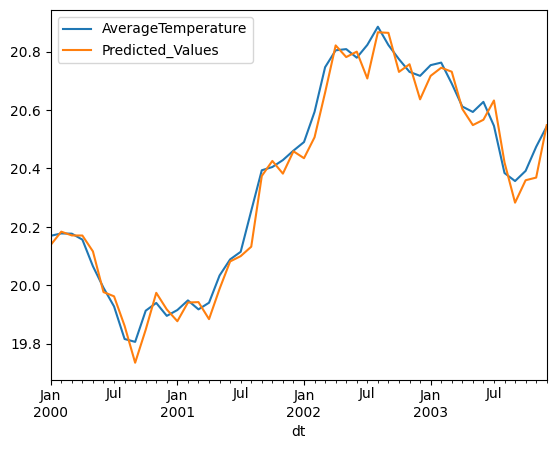

In [ ]:
result_df2[["AverageTemperature","Predicted_Values"]].plot()

In [ ]:
result_df = pd.DataFrame()

# Initialize counters for stationary and non-stationary countries
stationary_count_first_round = 0
non_stationary_count_first_round = 0

stationary_count_second_round = 0
non_stationary_count_second_round = 0
# Define the range of p and q values to search
max_p = 10
max_q = 10

for i, j in df_country:
    # Extract the last rows with similar shape
    data = j.copy()
    data = data.tail(least_rows)
    
    # Perform seasonal decomposition
    result = seasonal_decompose(data.AverageTemperature, model='additive', period=12)
    
    # Get the trend component and drop NaN values
    trend_components = result.trend.dropna()
    
    # Ensure the indices match
    trend_components.index = data.index[-len(trend_components):]
    
    # Add the 'Trend' column to the data DataFrame
    data["Trend"] = trend_components
    
    # Concatenate the current data DataFrame with the result DataFrame
    data = data.dropna()
    data_to_use = data["Trend"]
    data_to_use = pd.DataFrame(data_to_use)
    data_to_use.rename(columns={"Trend": "AverageTemperature"}, inplace=True)
    
    # Check for stationarity using ADF test
    adf = adf_check(data_to_use["AverageTemperature"], "AIC")
    
    
    # Check if p-value is less than 0.5
    if adf[1] <= 0.05:
        stationary_count_first_round += 1
        # Time series is stationary
        # Find the best (p, q) orders using the best_model_arma function
        best_mse, best_rmse = best_model_arma(data_to_use, max_p, max_q)
        # Run ARMA with the best (p, q) orders
        results = ARMA(data_to_use, best_rmse[0], best_rmse[1])
        
        if results is not None:
            a = results[0]
            a["Country"] = j["Country"]
            a["Country_ISO"] = j["Country_ISO"]
            result_df = pd.concat([result_df, a])
    else:
        non_stationary_count_first_round += 1
        #Time series is non-stationary
        # Perform necessary steps to make it stationary and then run ARMA
        original_data = data_to_use.copy()
        data_to_use["AverageTemperature"] = data_to_use["AverageTemperature"].diff().diff(12).dropna()
        
        data_to_use = data_to_use.dropna()
        
        adf = adf_check(data_to_use["AverageTemperature"], "AIC")
    
        # Check if p-value is less than 0.5
        if adf[1] <= 0.05:
            stationary_count_second_round += 1
            # Time series is stationary
            # Find the best (p, q) orders using the best_model_arma function
            best_mse, best_rmse = best_model_arma(data_to_use, max_p, max_q)
            # Run ARMA with the best (p, q) orders
            results = ARMA(data_to_use, best_rmse[0], best_rmse[1])
        
            if results is not None:
                a = results[0]
                #print(a)
                a.AverageTemperature += a.shift(1).AverageTemperature
                a.AverageTemperature += a.diff().shift(12).AverageTemperature
                a.Predicted_Values += a.shift(1).Predicted_Values 
                a.Predicted_Values += a.diff().shift(12).Predicted_Values
                a["Country"] = j["Country"]
                a["Country_ISO"] = j["Country_ISO"]
                result_df = pd.concat([result_df, a])
        else:
            non_stationary_count_second_round += 1
       

In [ ]:
result_df

,AverageTemperature,Shifted_values_1,Shifted_values_2,Predicted_Values,Country,Country_ISO,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10
dt,,,,,,,,,,,,,,
1884-04-01,13.697302,0.068042,0.267115,NaN,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1884-05-01,13.591484,-0.205203,0.068042,NaN,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1884-06-01,13.478026,-0.200307,-0.205203,NaN,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1884-07-01,13.394693,-0.144484,-0.200307,NaN,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1884-08-01,13.327891,-0.149635,-0.144484,NaN,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-04-01,20.177887,-0.083863,-0.107006,20.052298,Zimbabwe,ZWE,-0.053327,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01,20.186512,0.096911,-0.083863,20.205641,Zimbabwe,ZWE,-0.107006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-01,20.193464,0.079589,0.096911,20.167078,Zimbabwe,ZWE,-0.083863,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(stationary_count_first_round)
print(non_stationary_count_first_round)
print(stationary_count_second_round)
print(non_stationary_count_second_round)

60
99
99
0


In [ ]:
result_df2 = result_df.loc[(result_df.index >= "2000-01-01") & (result_df.index <= "2003-12-01")]

In [ ]:
result_df2 = result_df2[result_df2["Country"]=="Norway"]

<Axes: xlabel='dt'>

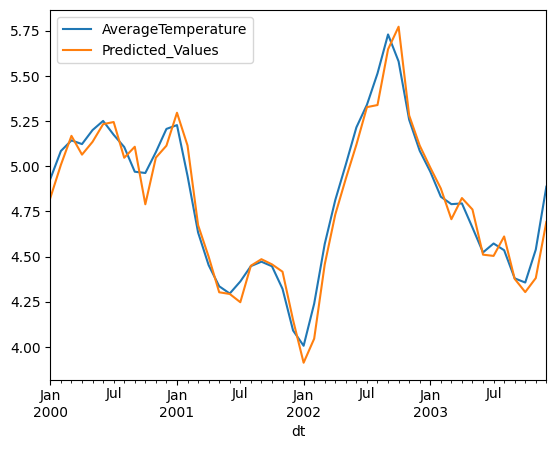

In [ ]:
result_df2[["AverageTemperature","Predicted_Values"]].plot()

In [ ]:
df_country_year_grouped = df_country_year.groupby("Country",observed=False)

rows = df_country_year_grouped.size()
least_rows = df_country_year_grouped.min()